# Audio Classification using Neural Networks
## GTECH78518 Final Project

- **Author:** Deana Baron
- **Date:** 5/21/19

Much of machine learning is focused on image classifications, but there are other datasets that can be classified as well. Audio data is all around us, and constantly being processed by the brain. Can we train a computer to also discern from different audio inputs like our brains do? Of course! Audio data is available in a format readable by a computer, notably .wav and .mp3 files. If a computer can read them, then audio data can be an input into a machine for classification.

Audio data is unstructured, however, and there is some preprocessing that needs to occur before using the data to train a model. Raw audio data contains many data points that make using the raw data cumbersome with machine learning.

To start, I will be using the ESC-10 and ESC-50 dataset. The ESC-50 dataset is a collection of 2,000 labeled audio clips of about 5 seconds in length, representing 50 total classes. The ESC-10 dataset is a subset of ESC-50 with 400 samples and 10 total classes. There's a lack of good, consistent, and labelled sound data that makes this sort of analysis on other things tedious.

Before doing anything else, let's look at our raw data.

### Part 1: Feature Visualization and Extraction

In [1]:
# import necessary libraries
import os
import numpy as np
import pandas as pd
import librosa
from librosa import display
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics 

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.metrics import confusion_matrix
import seaborn as sn

plt.style.use('seaborn')
%matplotlib inline

Using TensorFlow backend.


Loading raw audio files into Python is easy with the library `librosa`. We'll use this library to extract the waveforms of the ten different classes in the ESC-10 dataset. `librosa` returns a numpy array of the data values and the sampling rate with which the data was extracted from. The sampling rate is just the rate at which values are taken from the raw file.

Using `librosa`, we can also plot the waveforms of the audio files and compare and contrast what they look like between the different classes.

In [2]:
# function to load the raw sound files
def load_sound_files(audio_dir, file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(audio_dir + fp)
        raw_sounds.append(X)
    return raw_sounds

# plot the waveforms of the audio files, grouped int categories
def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,10), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(2,5,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot',x=0.5, y=0.95,fontsize=18)
    plt.show()

In [4]:
# load 10 example clips and their respective labeled categories
sound_file_names = ["1-100032-A-0.wav", "1-116765-A-41.wav", "1-17150-A-12.wav", "1-172649-A-40.wav",
                   "1-17367-A-10.wav", "1-187207-A-20.wav", "1-21934-A-38.wav", "1-26143-A-21.wav", 
                   "1-26806-A-1.wav", "1-28135-A-11.wav"]
sound_names = ["dog", "chainsaw", "crackling_fire", "helicopter", "rain", "crying_baby",
              "clock_tick", "sneezing", "rooster", "Sea_waves"]

# set the main directory
audio_dir = 'data/ESC-50-master/audio/'

# get the raw numpy arrays and plot the resulting waveforms
raw_sounds = load_sound_files(audio_dir, sound_file_names)
plot_waves(sound_names, raw_sounds)

We can see right away (without even listening to the clips) that all ten classes have a distinct pattern, although some classes look more alike than others. Now we can load and extract the data in a form that's more easily consumed.

In [6]:
# set data directory
data_dir = 'data//ESC-50-master'

#load the data as a pandas dataframe, filter for the ESC-10 data
main = pd.read_csv(os.path.join(os.path.abspath(data_dir), 'meta', 'esc50.csv'))
main = main[main['esc10']==True]
main.head()

filename  fold  target        category  esc10  src_file take
0    1-100032-A-0.wav     1       0             dog   True    100032    A
14   1-110389-A-0.wav     1       0             dog   True    110389    A
24  1-116765-A-41.wav     1      41        chainsaw   True    116765    A
54   1-17150-A-12.wav     1      12  crackling_fire   True     17150    A
55  1-172649-A-40.wav     1      40      helicopter   True    172649    A

The CSV that comes with the data gives us an easy way to load the data and its corresponding label. It also contains a 'fold' category, which presorts the data into different groups. This is what we'll use to split our data manually into training, validation, and testing without doing a random split. There are 5 folds total.

Like I said before, we can't use the raw sounds for machine learning since it is just too much data and too computationally intensive. There are many methods that can get a representative sample of the audio file in a numerical format for processing. The one we will be using is called Mel-frequency cepstral coefficients (MFCCs). These are complicated, but it's a method that has been used for automatic speech recognition and is considered a relatively simple and concise way to retrieve a representative sample of the audio file.

In [7]:
# function used to read each filename, load the raw file, and then parse it to mfccs and return with its associated label
def parser(row):
  #print(row.filename)
  try:
    filename=os.path.join(os.path.abspath(data_dir), 'audio', str(row.filename))
    x,s=librosa.load(filename,res_type='kaiser_fast')
    mfccs=np.mean(librosa.feature.mfcc(y=x,sr=s,n_mfcc=40).T,axis=0)
  except Exception as e:
    print('Error in ',filename)
    return None,None
  feature=mfccs
  label=row.category
  return feature, label

# load the folds for 
folds = []
for k in range(1,6):
        fold_name = 'fold' + str(k)
        print("\nSaving " + fold_name)
        fold = main[main['fold']==k]
        temp = fold.apply(parser,axis=1)
        temp = temp.apply(pd.Series, index=['feature', 'label'])
        folds.append(temp)


Saving fold1

Saving fold2

Saving fold3

Saving fold4

Saving fold5


In [8]:
# let's load the folds separately and look at one
fold1, fold2, fold3, fold4, fold5 = folds
fold1.head()

feature           label
0   [-601.3449448083927, 5.2614082261637884, -9.06...             dog
14  [-586.3389716036638, 10.611191480789373, -3.35...             dog
24  [-66.6323609093118, 95.38643518317879, -41.731...        chainsaw
54  [-293.0566941945905, 71.62378290181326, 9.7724...  crackling_fire
55  [-30.870784013500153, 44.658841822557235, 42.4...      helicopter

### Part 2: Model Building and Training

Now that we have our representative numpy arrays and labels for our files, we can start building the model.

The first step is to split the data manually into training, validation, and testing. Since we have 5 folds, folds 1, 2, and 3 will be used for training, fold 4 will be used for validation, and fold 5 will be used for testing. For these three sets, we need to get a numpy array containing all of the values, and a numpy array containing all of the corresponding labels for those values.

Next we need to convert the categorical labels to numerical values. The `LabelEncoder` converts the categories to a numerical equivalent, and then the next function converts these numeric labels into a binary matrix configuration.

In [9]:
# append folds 2 and 3 to fold 1 for training
fold1 = fold1.append([fold2, fold3])

# training data
X = np.array(fold1.feature.tolist())
y = np.array(fold1.label.tolist())

# validation data
valid_X = np.array(fold4.feature.tolist())
valid_y = np.array(fold4.label.tolist())

# testing data
test_X = np.array(fold5.feature.tolist())
test_y = np.array(fold5.label.tolist())

# label encoding 
lb = LabelEncoder()

# convert the labels to binary categorical matrices
y = np_utils.to_categorical(lb.fit_transform(y))
valid_y = np_utils.to_categorical(lb.fit_transform(valid_y))
test_y = np_utils.to_categorical(lb.fit_transform(test_y))

The model used here is a really (really...) simple neural network. This is a two layer neutral network, in which each layer represents a dense set of neurons. The first layer takes an input shape with 40 columns. The second layer does not need an input shape and infers it from the first layer. An activation is applied at each layer to affect the speed at which the model learns. The final layer represents the number of classes we have, and the activation is set specifically for multiclass classification. The output is a 1x10 array representing the score for each item and what class it belongs to. The model must then be compiled for before use, setting the loss function to a multiclass classification scheme, and an optimizer. 

In [11]:
# number of classes
num_labels = y.shape[1]
filter_size = 2

print("Building model...")
# build model
esc10_model = Sequential()

# input layer
esc10_model.add(Dense(256, input_shape=(40,)))
esc10_model.add(Activation('relu'))
esc10_model.add(Dropout(0.5))

# hidden layer
esc10_model.add(Dense(256))
esc10_model.add(Activation('relu'))
esc10_model.add(Dropout(0.5))

# layer for output
esc10_model.add(Dense(num_labels))
esc10_model.add(Activation('softmax'))

print("Model built. Compiling...")
# compile for multiclass classification
esc10_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

print("Compiling complete.")

Building model...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model built. Compiling...
Compiling complete.


Now we can fit the model to the training data, and validate it using the validation data. I set the epochs, or number of times for the model to go through the dataset to 50 times.

In [13]:
esc10_model.fit(X, y, batch_size=32, epochs=50, validation_data=(valid_X, valid_y))

Instructions for updating:
Use tf.cast instead.
Train on 240 samples, validate on 80 samples
Epoch 1/50
240/240 [==============================] - 1s 6ms/step - loss: 13.7907 - acc: 0.0917 - val_loss: 12.6667 - val_acc: 0.1125
Epoch 2/50
240/240 [==============================] - 0s 256us/step - loss: 12.7579 - acc: 0.1583 - val_loss: 11.8970 - val_acc: 0.1250
Epoch 3/50
240/240 [==============================] - 0s 160us/step - loss: 12.9066 - acc: 0.1292 - val_loss: 9.7936 - val_acc: 0.2250
Epoch 4/50
240/240 [==============================] - 0s 197us/step - loss: 12.5820 - acc: 0.1458 - val_loss: 8.3052 - val_acc: 0.2750
Epoch 5/50
240/240 [==============================] - 0s 168us/step - loss: 12.7368 - acc: 0.1500 - val_loss: 10.2075 - val_acc: 0.2250
Epoch 6/50
240/240 [==============================] - 0s 160us/step - loss: 11.4141 - acc: 0.2208 - val_loss: 10.5408 - val_acc: 0.2250
Epoch 7/50
240/240 [==============================] - 0s 171us/step - loss: 10.8720 - acc: 0.24

### Part 3: Evaluating the Model

Now let's evaluate the model against the training data, which the model has not seen.

In [14]:
# function for evaluating the model
def evaluate(model):
    y_prob = model.predict_proba(test_X, verbose=0)
    y_pred = y_prob.argmax(axis=-1)
    y_true = np.argmax(test_y, 1)

    roc = metrics.roc_auc_score(test_y, y_prob) 
    print ("ROC:",  round(roc,3))
    
    # evaluate the model
    score, accuracy = model.evaluate(test_X, test_y, batch_size=32)
    print("\nAccuracy = {:.2f}".format(accuracy))

    # the F-score gives a similiar value to the accuracy score, but useful for cross-checking
    p,r,f,s = metrics.precision_recall_fscore_support(y_true, y_pred, average='micro')
    print ("F-Score:", round(f,2))
    
    return roc, accuracy

In [15]:
# now evaluate the trained model against the unseen test data
print("Evaluating model...")
roc, acc = evaluate(esc10_model)

Evaluating model...
ROC: 0.794
80/80 [==============================] - 0s 230us/step

Accuracy = 0.53
F-Score: 0.52


The first step is the Area Under the Receiver Operating Characteristic Curve (ROC AUC). This is a summary of the fraction of true positive values versus false positive values for the classification. The closer to 1 it is, the better it is at classifying. The F-score is another way to measure the accuracy.

We can also make a confusion matrix to visualize how well the model classified the test data.

Showing Confusion Matrix


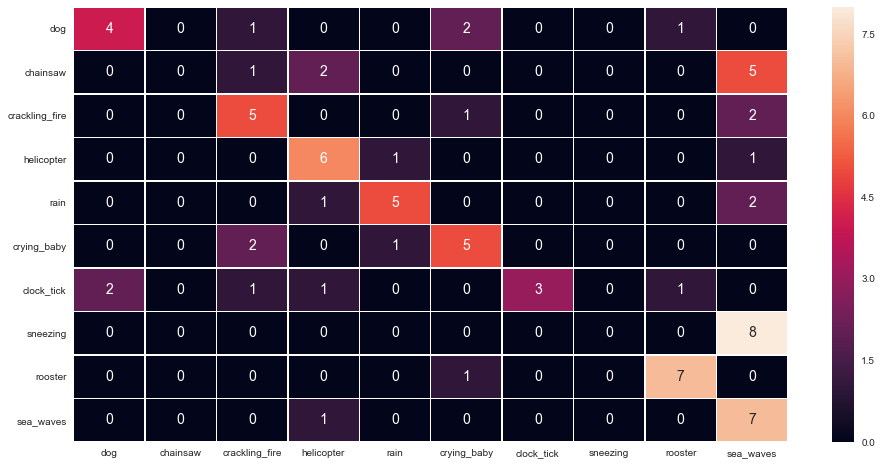

In [20]:
# make a confusion matrix
labels = list(main.category.unique())
print ("Showing Confusion Matrix")
y_prob = esc10_model.predict_proba(test_X, verbose=0)
y_pred = y_prob.argmax(axis=-1)
y_true = np.argmax(test_y, 1)
cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize = (16,8))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5);

## How good is this model for the whole dataset?

We see that the model was fair at classifying the test data for 10 classes, but how does it stack up to doing the entire dataset with 2,000 samples and 50 classes?

In [21]:
data_dir = 'data//ESC-50-master'

#load the training data
data = pd.read_csv(os.path.join(os.path.abspath(data_dir), 'meta', 'esc50.csv'))
data.head()

filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

In [22]:
folds = []
for k in range(1,6):
        fold_name = 'fold' + str(k)
        print("\nSaving " + fold_name)
        fold = data[data['fold']==k]
        temp = fold.apply(parser,axis=1)
        temp = temp.apply(pd.Series, index=['feature', 'label'])
        folds.append(temp)

fold1, fold2, fold3, fold4, fold5 = folds
fold1.head()


Saving fold1

Saving fold2

Saving fold3

Saving fold4

Saving fold5


feature           label
0  [-601.3449448083927, 5.2614082261637884, -9.06...             dog
1  [-200.6590950605688, 12.515456415611, -69.0336...  chirping_birds
2  [7.545552539995936, 69.50337381031626, -21.425...  vacuum_cleaner
3  [8.940391242994824, 67.527899346432, -19.81801...  vacuum_cleaner
4  [-428.3764441430584, 132.65819143400054, 31.13...    thunderstorm

In [23]:
fold1 = fold1.append([fold2, fold3])
X = np.array(fold1.feature.tolist())
y = np.array(fold1.label.tolist())

valid_X = np.array(fold4.feature.tolist())
valid_y = np.array(fold4.label.tolist())

test_X = np.array(fold5.feature.tolist())
test_y = np.array(fold5.label.tolist())

lb2 = LabelEncoder()

y = np_utils.to_categorical(lb2.fit_transform(y))
valid_y = np_utils.to_categorical(lb2.fit_transform(valid_y))
test_y = np_utils.to_categorical(lb2.fit_transform(test_y))

In [24]:
num_labels = y.shape[1]
filter_size = 2

# build model
esc50_model = Sequential()

esc50_model.add(Dense(256, input_shape=(40,)))
esc50_model.add(Activation('relu'))
esc50_model.add(Dropout(0.5))

esc50_model.add(Dense(256))
esc50_model.add(Activation('relu'))
esc50_model.add(Dropout(0.5))

esc50_model.add(Dense(num_labels))
esc50_model.add(Activation('softmax'))

esc50_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [25]:
esc50_model.fit(X, y, batch_size=32, epochs=50, validation_data=(valid_X, valid_y))

Train on 1200 samples, validate on 400 samples
Epoch 1/50
1200/1200 [==============================] - 2s 1ms/step - loss: 15.3673 - acc: 0.0233 - val_loss: 15.2367 - val_acc: 0.0250
Epoch 2/50
1200/1200 [==============================] - 0s 225us/step - loss: 15.3608 - acc: 0.0300 - val_loss: 15.3002 - val_acc: 0.0300
Epoch 3/50
1200/1200 [==============================] - 0s 208us/step - loss: 15.3478 - acc: 0.0242 - val_loss: 14.4289 - val_acc: 0.0625
Epoch 4/50
1200/1200 [==============================] - 0s 213us/step - loss: 15.0569 - acc: 0.0442 - val_loss: 14.4074 - val_acc: 0.0625
Epoch 5/50
1200/1200 [==============================] - 0s 210us/step - loss: 14.8814 - acc: 0.0467 - val_loss: 14.5239 - val_acc: 0.0600
Epoch 6/50
1200/1200 [==============================] - 0s 213us/step - loss: 15.0443 - acc: 0.0433 - val_loss: 14.5572 - val_acc: 0.0725
Epoch 7/50
1200/1200 [==============================] - 0s 211us/step - loss: 14.8629 - acc: 0.0508 - val_loss: 13.8785 - val_a

In [26]:
def evaluate(model):
    y_prob = model.predict_proba(test_X, verbose=0)
    y_pred = y_prob.argmax(axis=-1)
    y_true = np.argmax(test_y, 1)

    roc = metrics.roc_auc_score(test_y, y_prob)
    print ("ROC:",  round(roc,3))
    
    # evaluate the model
    score, accuracy = model.evaluate(test_X, test_y, batch_size=32)
    print("\nAccuracy = {:.2f}".format(accuracy))

    # the F-score gives a similiar value to the accuracy score, but useful for cross-checking
    p,r,f,s = metrics.precision_recall_fscore_support(y_true, y_pred, average='micro')
    print ("F-Score:", round(f,2))
    
    return roc, accuracy

In [27]:
# now evaluate the trained model against the unseen test data
print("Evaluating model...")
roc, acc = evaluate(esc50_model)

Evaluating model...
ROC: 0.762
400/400 [==============================] - 0s 50us/step

Accuracy = 0.14
F-Score: 0.14


Showing Confusion Matrix


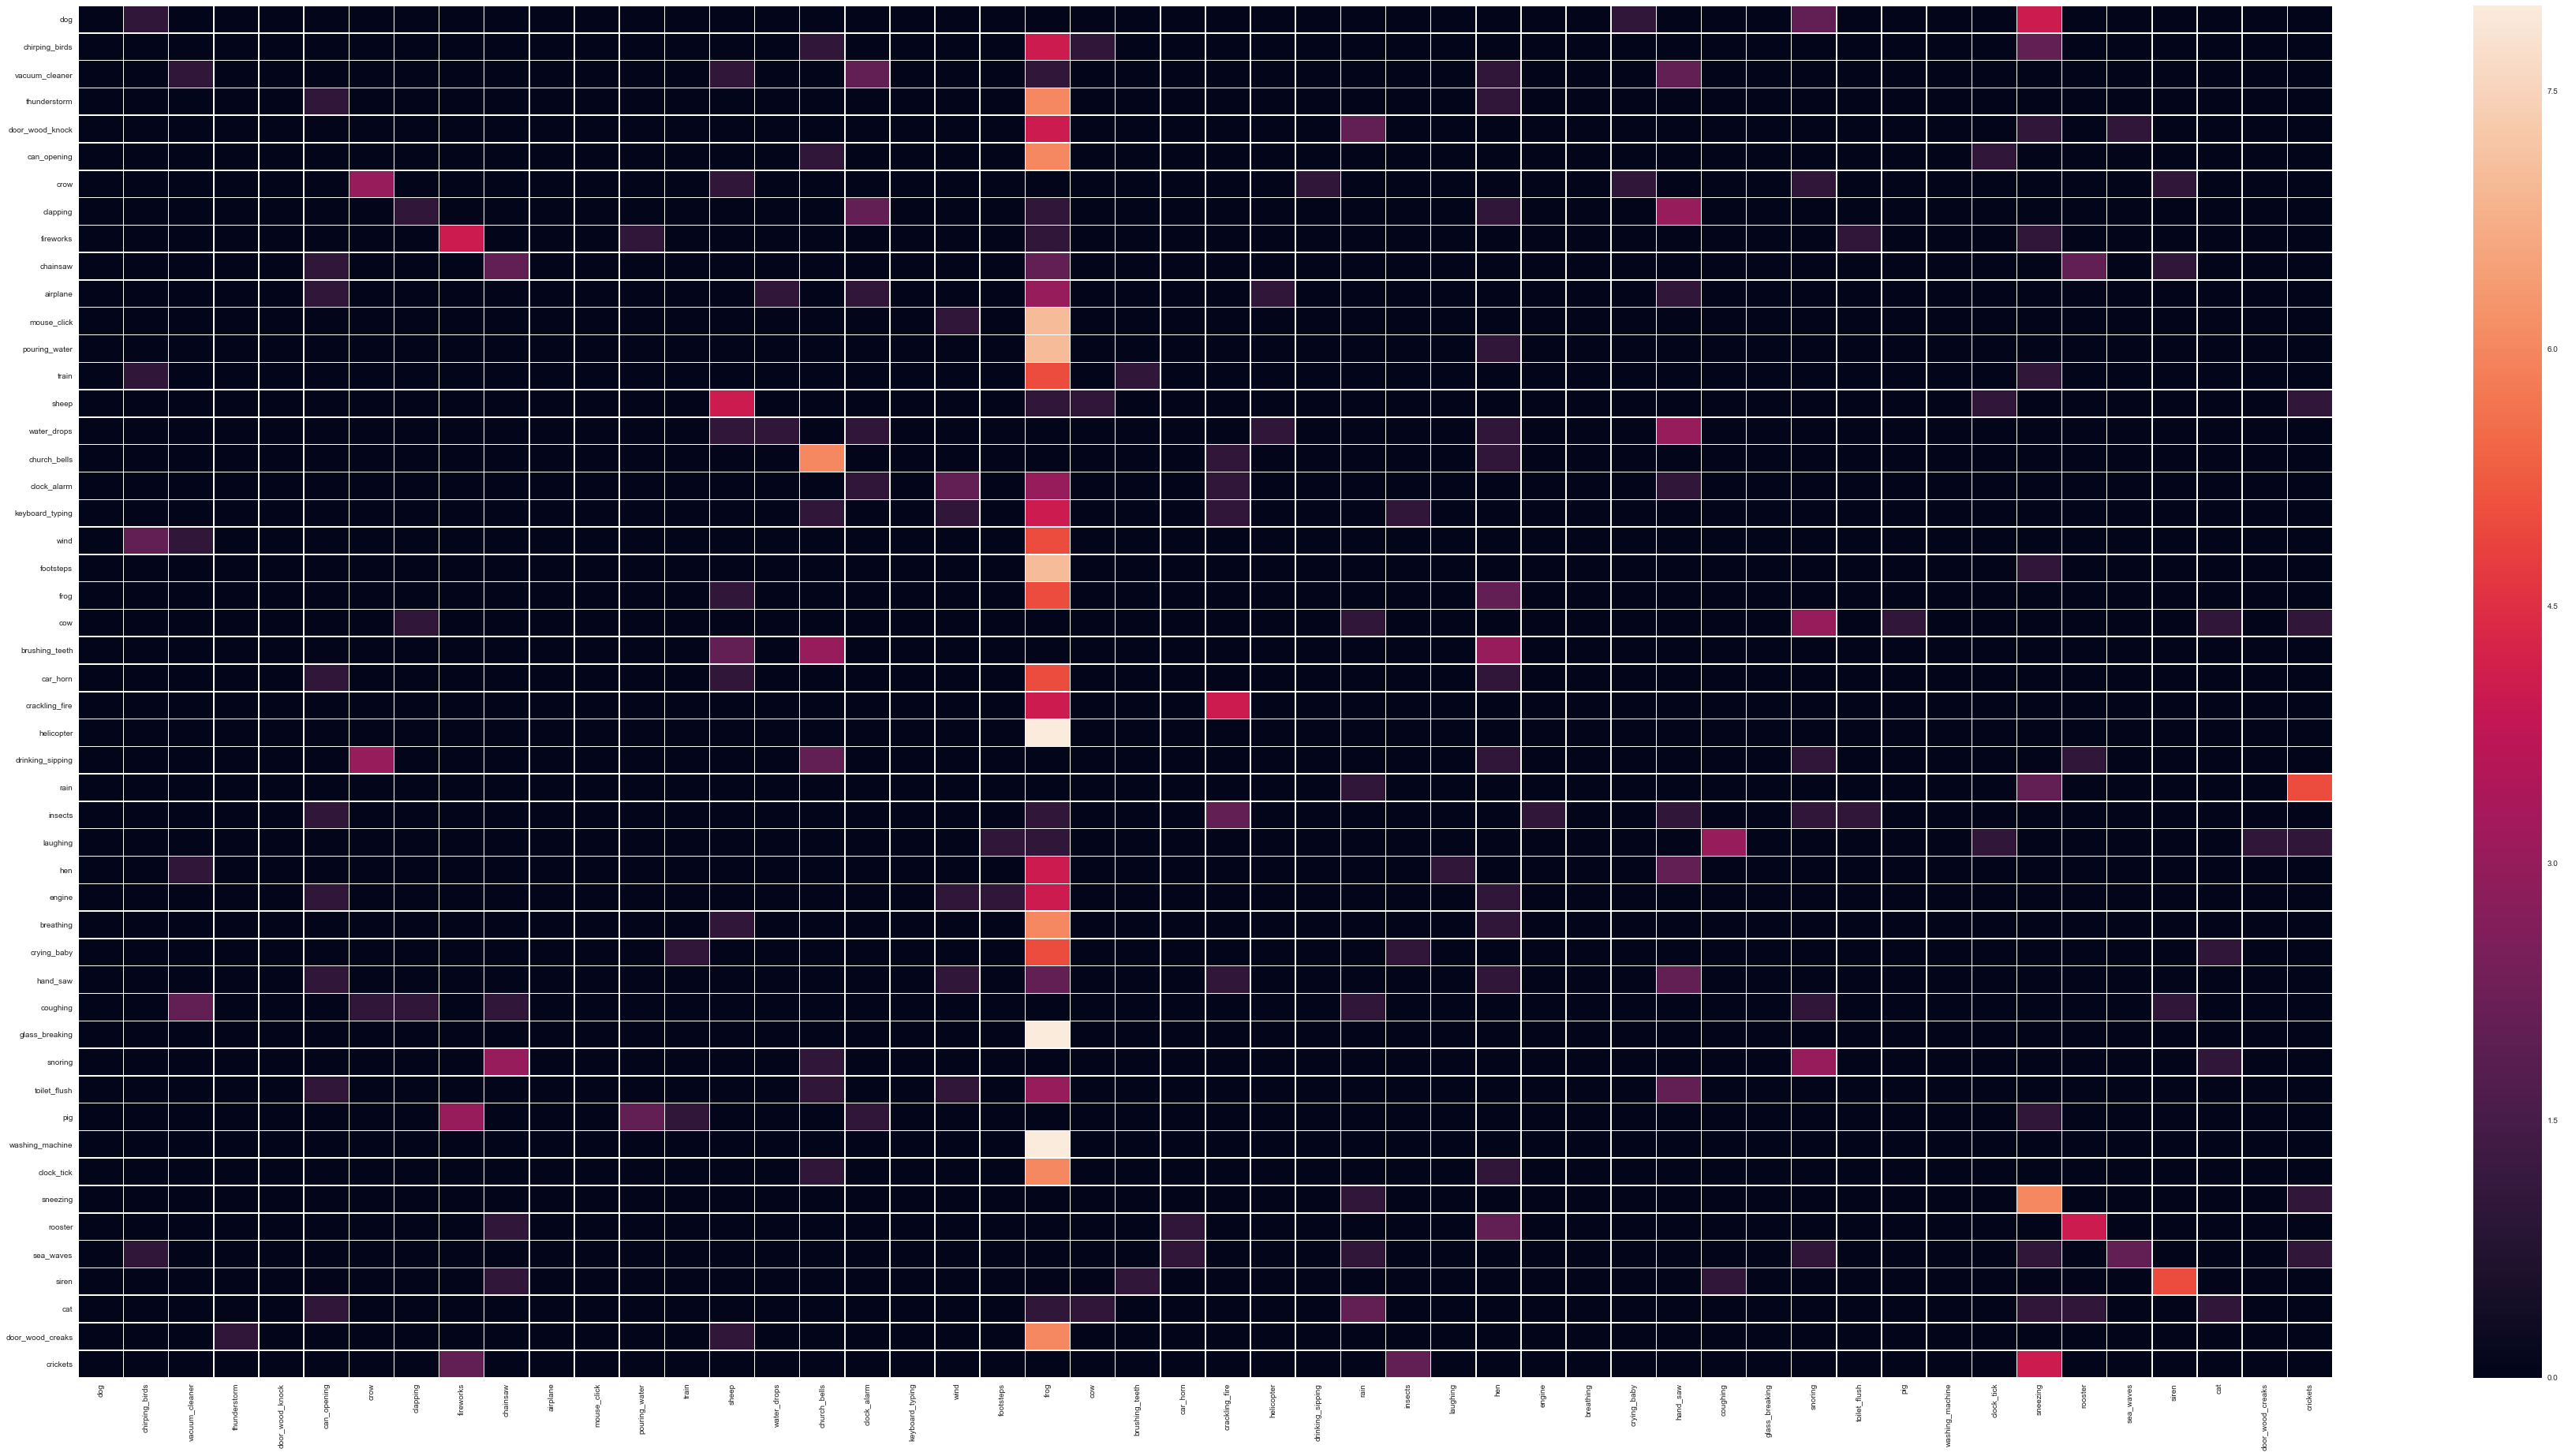

In [28]:
labels = list(data.category.unique())
print ("Showing Confusion Matrix")
y_prob = esc50_model.predict_proba(test_X, verbose=0)
y_pred = y_prob.argmax(axis=-1)
y_true = np.argmax(test_y, 1)
cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize = (64,32))
sn.heatmap(df_cm, annot=False, annot_kws={"size": 14}, fmt='g', linewidths=.5);

Definitely not as good as with 10 classes! Like I said, this is a really simple neural network, and I only did 50 epochs. There are better neural networks that do well with classifying audio data, like recurrent neural networks (RNNs) and convolutional neural networks (CNNs), which are also much harder to implement but produce better results.

Audio classification has a lot of different uses like for genre classification and song identification, but there is also a field of environmental sound classifications. In marine science, bioacoustics is a hot topic, and the idea of being able to classify passive acoustic recordings from very long video and audio files is exciting. So many of ocean's lifeforms rely on sound as their primary method of hunting, mating, and deciding whether they need to flee. Unfortunately, there aren't many labeled and compiled datasets that would allow for this sort of analysis, or they aren't publicly available. It would be interesting in the future to try a much more complicated neural network that is better for audio classification, as well as using an ocean sound database to classify different animal species, other natural sounds, and anthropogenic sounds.

### References

- Piczak, K. J. (2015, October). ESC: Dataset for environmental sound classification. In Proceedings of the 23rd ACM international conference on Multimedia (pp. 1015-1018). ACM.
- Salamon, J., & Bello, J. P. (2017). Deep convolutional neural networks and data augmentation for environmental sound classification. IEEE Signal Processing Letters, 24(3), 279-283.

